# Selecting Praesepe members, compiling data and fitting a gyrochronology relation

This notebook reproduces figures in the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [2]:
douglas = pd.read_csv("../../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [3]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [4]:
with fits.open('../../data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)
bedell.keys()

c5_mask = bedell.k2_campaign_str.values == "5"
c5 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c5_mask], 
                        "EPIC": bedell.epic_number.values[c5_mask], 
                        "ra": bedell.ra.values[c5_mask], 
                        "dec": bedell.dec.values[c5_mask], 
                        "G": bedell.phot_g_mean_mag.values[c5_mask],
                        "bp": bedell.phot_bp_mean_mag.values[c5_mask],
                        "rp": bedell.phot_rp_mean_mag.values[c5_mask],
                        "parallax": bedell.parallax.values[c5_mask],
                        "parallax_err": bedell.parallax_error.values[c5_mask],
                       }))

Text(0,0.5,'Dec')

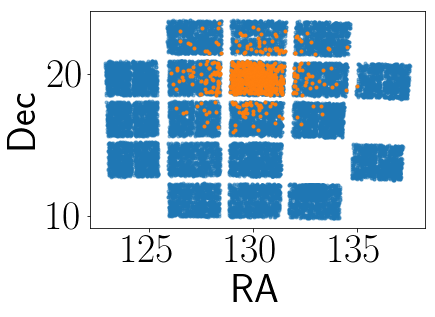

In [5]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [6]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 9) (794, 29) (757, 37)


Text(0,0.5,'Dec')

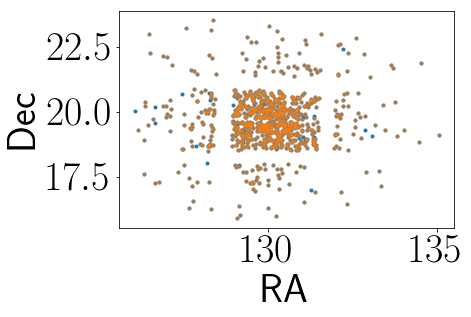

In [7]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

In [279]:
df.keys()

Index(['EPIC', 'G', 'bp', 'dec', 'parallax', 'parallax_err', 'ra', 'rp',
       'source_id', 'Name', 'Mass', 'r'mag', 'Kmag', 'Prot1', 'Pw1', 'Q1',
       'Clean?', 'Sig', 'Prot2', 'Pw2', 'Q2', 'MP?', 'SE?', 'Bl?', 'Bin?',
       'RawAmp', 'SmAmp', 'P', 'Kpmag', 'PrCat', 'PCat', 'All', '2M', 'Simbad',
       '_RA', '_DE', 'period'],
      dtype='object')

In [11]:
gaia_color = df.bp - df.rp
Mdwarf_cut = 2.4
m_mask = gaia_color < Mdwarf_cut

# plt.figure(figsize=(16, 9))
# plt.loglog(gaia_color, df.period, ".", ms=10)
# plt.loglog(gaia_color[~color_mask], df.period[~color_mask], ".", color="tab:orange", ms=10)
# plt.xlabel("$G_{BP} - G_{RP}$")
# plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.xlim(10**-.3, 10**.6)
# plt.axvline(Mdwarf_cut, color=".5", ls="--")
# plt.savefig("../praesepe.pdf")

Remove outliers using sigma clipping.

In [12]:
def sigma_clip(x, y):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y = x[finite_mask], y[finite_mask]
    new_x, new_y = x*1, y*1
    
    for i in range(10):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < 4.5*sigma
        new_x, new_y = new_x[outlier_mask], new_y[outlier_mask]
    
    return new_x, new_y

x_clipped, y_clipped = sigma_clip(np.log10(gaia_color[m_mask]), np.log10(df.period[m_mask]))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Now fit a model

In [13]:
praesepe_age = 650
sun_age, sun_prot, sun_color = np.array([4.56]), np.array([26]), np.array([.82])

x = np.concatenate((x_clipped, np.log10(sun_color)))
y = np.concatenate((y_clipped, np.log10(sun_prot)))
z = np.concatenate((np.log10(np.ones_like(x_clipped)*praesepe_age), np.log10(sun_age)))

finite_mask = np.isfinite(x) * np.isfinite(y) * np.isfinite(z)
x, y, z = x[finite_mask], y[finite_mask], z[finite_mask]

sigma = z*.1  # 10% uncertainties
sigma[-1] = sun_age * .01 # 1% uncertainty for the Sun 

AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
ATA = np.dot(AT, AT.T)
p = np.linalg.solve(ATA, np.dot(AT, y))
p

array([  1.68846515,   0.6183025 ,  -4.452133  ,  31.02877576,
       -47.76497323,  -0.24983436])

In [17]:
# plt.figure(figsize=(16, 9))

# plt.plot(x, y, ".", ms=8, zorder=0)
# plt.plot(np.log10(sun_color), np.log10(sun_prot), ".k", zorder=0)  # Casagrande 2018
# plt.scatter(np.log10(sun_color)+.0005, np.log10(sun_prot)-.002, s=150, 
#             facecolors="none", edgecolors="k", zorder=0)
# plt.xlabel("$G_{BP} - G_{RP}$")
# plt.ylabel("$\mathrm{Rotation~period~[days]}$")

xs = np.linspace(-.25, .38, 100)
# plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age),
#          color="k", ls="--", lw=1, zorder=0, alpha=.8)
# plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age),
#          color="k", ls="--", lw=1, zorder=0, alpha=.8)

Plotting everything together.

In [18]:
# plt.figure(figsize=(16, 9))

# # Full cluster
# plt.loglog(gaia_color, df.period, "wo", ms=5, markeredgecolor="tab:orange")
# plt.loglog(gaia_color[~color_mask], df.period[~color_mask], "wo", markeredgecolor="tab:orange", ms=5)
# plt.axvline(Mdwarf_cut, color="k", alpha=.5, lw=1)

# # Sigma clipped
# plt.loglog(10**x_clipped, 10**y_clipped, ".", ms=11, color="tab:blue")

# # Sun
# plt.loglog(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=3)
# plt.loglog(sun_color, sun_prot, ".k", zorder=3)  # Casagrande 2018

# # model
# plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age)),
#          color="k", ls="--", lw=2, zorder=2)
# plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age)),
#          color="k", ls="--", lw=2, zorder=0)

# # Floof
# # plt.xlim(10**-.3, 10**.6)
# plt.xlabel("$G_{BP} - G_{RP}$")
# plt.ylabel("$\mathrm{Rotation~period~[days]}$")

# plt.savefig("praesepe_outliers.pdf")

Now add the angus2015 models

In [19]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3


def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    return bv_iter[np.argmin(diffs**2)]


def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

bv = np.zeros_like(xs)
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
periods_praesepe = gyro_model(np.log10(625*1e6), bv)
periods_sun = gyro_model(np.log10(4.56*1e9), bv)

print(bv_2_bprp(.65))
print(bprp_2_bv(.82))

1.0172599624999998
0.5094509450945095


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in log10


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


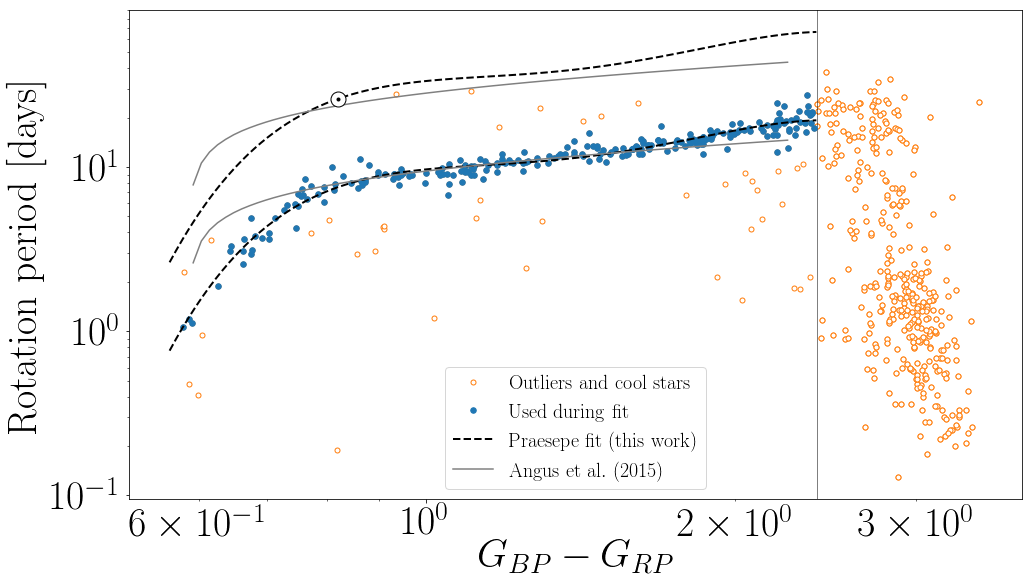

In [20]:
plt.figure(figsize=(16, 9))

# Full cluster
plt.loglog(gaia_color, df.period, "wo", ms=5, markeredgecolor="tab:orange", 
          label="$\mathrm{Outliers~and~cool~stars}$")
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], "wo", markeredgecolor="tab:orange", ms=5,
          label="$\mathrm{Outliers~and~cool~stars}$")
plt.axvline(Mdwarf_cut, color="k", alpha=.5, lw=1)

# Sigma clipped
plt.loglog(10**x_clipped, 10**y_clipped, ".", ms=11, color="tab:blue", label="$\mathrm{Used~during~fit}$")

# Sun
plt.loglog(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=3)
plt.loglog(sun_color, sun_prot, ".k", zorder=3)  # Casagrande 2018

# model
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age)),
         color="k", ls="--", lw=2, zorder=2, label="$\mathrm{Praesepe~fit~(this~work)}$")
plt.loglog(10**xs, 10**(p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age)),
         color="k", ls="--", lw=2, zorder=0, label="$\mathrm{Praesepe~fit~(this~work)}$")

plt.loglog(10**xs-.15, periods_praesepe, color=".5", label="$\mathrm{Angus~et ~al.~(2015)}$")
plt.loglog(10**xs-.15, periods_sun, color=".5", label="$\mathrm{Angus~et ~al.~(2015)}$")

# Floof
# plt.xlim(10**-.3, 10**.6)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.legend()
plt.savefig("with_angus_gyrochrones.pdf")